### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [0]:
!sudo pip uninstall keras
!sudo pip install keras==2.1.6

Uninstalling Keras-2.1.6:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.1.6.dist-info/*
    /usr/local/lib/python3.6/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled Keras-2.1.6
  Using cached https://files.pythonhosted.org/packages/54/e8/eaff7a09349ae9bd40d3ebaf028b49f5e2392c771f294910f75bb608b241/Keras-2.1.6-py2.py3-none-any.whl


In [0]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-04-19 16:26:42--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import cv2
from random import randint

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)
CROP_SIZE = (48,48)

def extract_no_sign_crop(img, sign_bbox):
    h = img.shape[0]
    w = img.shape[1]
    h2 = int(img.shape[0]/2)
    w2 = int(img.shape[1]/2)
    
    area = 0
    
    while(area != CROP_SIZE[0]*CROP_SIZE[1]):
        point_quad1 = [randint(0,h2),randint(0,w2)]
        point_quad2 = [randint(0,h2),randint(w2+1,w - CROP_SIZE[1])]
        point_quad3 = [randint(h2+1,h - CROP_SIZE[0]),randint(w2+1,w - CROP_SIZE[1])]
        point_quad4 = [randint(h2+1,h - CROP_SIZE[0]),randint(0,w2)]

        point = point_quad1 # default

        if (sign_bbox is not None):
            # a better choice is possible
            if (sign_bbox[0] > w2 and sign_bbox[1] > h2):
                # sign is in quad2
                point = point_quad4 # take from quad4
            elif (sign_bbox[0] < w2 and sign_bbox[1] > h2):
                # sign is in quad1
                point = point_quad3 # take from quad3
            elif (sign_bbox[0] > w2 and sign_bbox[1] < h2):
                # sign is in quad3
                point = point_quad1 # take from quad1
            elif (sign_bbox[0] < w2 and sign_bbox[1] < h2):
                # sign is in quad4
                point = point_quad2 # take from quad2

        #im[y:y+h,x:x+w]  

        left = point[0]
        upper = point[1]
        right = point[0]+CROP_SIZE[1]
        lower = point[1]+CROP_SIZE[0]

        area = abs(left-right)*abs(upper-lower)
    #no_sign = img[int(upper):int(lower), int(left):int(right)]
    
    return [left, upper, right, lower]#no_sign


# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    no_signs = []
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        
        ns_bbox = extract_no_sign_crop(img, bbox)
        no_sign = img[int(ns_bbox[1]):int(ns_bbox[3]), int(ns_bbox[0]):int(ns_bbox[2])] 
        
        if(no_sign.shape[0] == CROP_SIZE[0] and no_sign.shape[1] == CROP_SIZE[1]):    
            #plt.imshow(cv2.cvtColor(no_sign, cv2.COLOR_BGR2RGB))
            #plt.show()
            no_signs.append(no_sign)
            
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels, no_signs


In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels, train_no_signs = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels, test_no_signs = readImages('FullIJCNN2013', range(600,900), range(852,1213))

In [0]:
for i in range(num_classes):
    plt.imshow(cv2.cvtColor(train_no_signs[int(randint(0,len(train_no_signs)))], cv2.COLOR_BGR2RGB))
    plt.show()

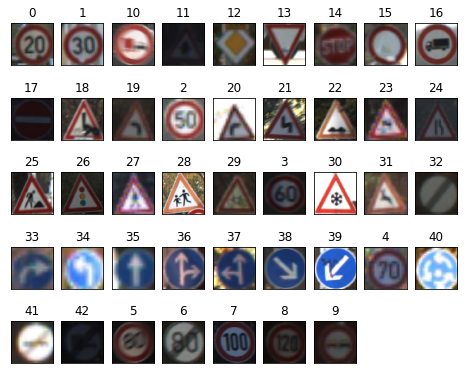

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
print(len(train_no_signs))
print(len(test_no_signs))
print(len(train_signs))
print(len(test_signs))


577
256
852
361


In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

#######################################
# create extra datasets for binary classifier

b_train_signs = []
b_test_signs = []

for i in range(len(train_signs)):
    resz = cv2.resize(train_signs[i], CROP_SIZE)
    b_train_signs.append(resz)

for i in range(len(test_signs)):
    resz = cv2.resize(test_signs[i], CROP_SIZE)
    b_test_signs.append(resz)

print(len(b_train_signs))
print(len(b_test_signs))
    
b_tr_signs = np.array(b_train_signs)[0:600]
b_tr_labels = np.array(train_labels)[0:600]
b_va_signs = np.array(b_train_signs)[600:852]
b_va_labels = np.array(train_labels)[600:852]
b_te_signs = np.array(b_test_signs)
b_te_labels = np.array(test_labels)

b_tr_labels.fill('1')
b_va_labels.fill('1')
b_te_labels.fill('1')

b_tr_signs = b_tr_signs.astype('float32')
b_va_signs = b_va_signs.astype('float32')
b_te_signs = b_te_signs.astype('float32')
b_tr_signs /= 255.0
b_va_signs /= 255.0
b_te_signs /= 255.0


b_tr_labels = np_utils.to_categorical(b_tr_labels, 2)
b_va_labels = np_utils.to_categorical(b_va_labels, 2)
b_te_labels = np_utils.to_categorical(b_te_labels, 2)

sep = int(len(train_no_signs)*0.7)

b_tr_no_signs = np.array(train_no_signs)[0:sep]
b_tr_no_labels = np.array(train_labels)[0:sep]
b_va_no_signs = np.array(train_no_signs)[sep:len(train_no_signs)]
b_va_no_labels = np.array(train_labels)[sep:len(train_no_signs)]
b_te_no_signs = np.array(test_no_signs)
b_te_no_labels = np.array(test_labels)[0:len(test_no_signs)]

b_tr_no_labels.fill('0')
b_va_no_labels.fill('0')
b_te_no_labels.fill('0')

b_tr_no_signs = b_tr_no_signs.astype('float32')
b_va_no_signs = b_va_no_signs.astype('float32')
b_te_no_signs = b_te_no_signs.astype('float32')
b_tr_no_signs /= 255.0
b_va_no_signs /= 255.0
b_te_no_signs /= 255.0

b_tr_no_labels = np_utils.to_categorical(b_tr_no_labels, 2)
b_va_no_labels = np_utils.to_categorical(b_va_no_labels, 2)
b_te_no_labels = np_utils.to_categorical(b_te_no_labels, 2)


b_tr_imgs = np.concatenate((b_tr_signs, b_tr_no_signs))
b_tr_labels = np.concatenate((b_tr_labels, b_tr_no_labels))

b_va_imgs = np.concatenate((b_va_signs, b_va_no_signs))
b_va_labels = np.concatenate((b_va_labels, b_va_no_labels))

b_te_imgs = np.concatenate((b_te_signs, b_te_no_signs))
b_te_labels = np.concatenate((b_te_labels, b_te_no_labels))


b_tr_imgs, b_tr_labels = shuffle(b_tr_imgs, b_tr_labels)
b_va_imgs, b_va_labels = shuffle(b_va_imgs, b_va_labels)
b_te_imgs, b_te_labels = shuffle(b_te_imgs, b_te_labels)

Using TensorFlow backend.


852
361


In [0]:
print(tr_signs.shape)
print(tr_labels.shape)

print(va_signs.shape)
print(va_labels.shape)

print(te_signs.shape)
print(te_labels.shape)

(600, 224, 224, 3)
(600, 43)
(252, 224, 224, 3)
(252, 43)
(361, 224, 224, 3)
(361, 43)


In [0]:
print(b_tr_imgs.shape)
print(b_tr_labels.shape)

print(b_va_imgs.shape)
print(b_va_labels.shape)

print(b_te_imgs.shape)
print(b_te_labels.shape)

(1003, 48, 48, 3)
(1003, 2)
(426, 48, 48, 3)
(426, 2)
(613, 48, 48, 3)
(613, 2)


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.4: Traffic sign detection

sudo pip install Keras==2.1.6

In [0]:
ANCHOR_RATIOS = (0.5, 1.0, 2.0)
ANCHOR_STRIDE = 16
ANCHOR_SIZES = (32, 64, 128, 256, 512)
MAX_SIZE = 1344
MIN_SIZE = 0

# Parameters to play with to modify the number of proposal in each image
TEST_PRE_NMS_TOPK = 8000 # The maximum number of positive samples taken during proposal generation, pre NMS
TEST_POST_NMS_TOPK = 1000 # The maximum number of positive samples taken during proposal generation, post NMS
PROPOSAL_NMS_THRESH = 0.7

In [0]:
"""Operations for [N, 4] numpy arrays representing bounding boxes.
Example box operations that are supported:
  * Areas: compute bounding box areas
  * IOU: pairwise intersection-over-union scores
"""
def area(boxes):
    """Computes area of boxes.
    Args:
    boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
    a numpy array with shape [N*1] representing box areas
    """
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def intersection(boxes1, boxes2):
    """Compute pairwise intersection areas between boxes.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes
    boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
    a numpy array with shape [N*M] representing pairwise intersection area
    """
    [x_min1, y_min1, x_max1, y_max1] = np.split(boxes1, 4, axis=1)
    [x_min2, y_min2, x_max2, y_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape, dtype='f4'),all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape, dtype='f4'),all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

def iou(boxes1, boxes2):
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding M boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def ioa(boxes1, boxes2):
    """Computes pairwise intersection-over-area between box collections.
    Intersection-over-area (ioa) between two boxes box1 and box2 is defined as
    their intersection area over box2's area. Note that ioa is not symmetric,
    that is, IOA(box1, box2) != IOA(box2, box1).
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding N boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise ioa scores.
    """
    intersect = intersection(boxes1, boxes2)
    inv_areas = np.expand_dims(1.0 / area(boxes2), axis=0)
    return intersect * inv_areas

def clip_boxes(bboxes, clip_box, alpha):
    """
    This function clip the bboxes to the border of the image

    :param bboxes: array of shape (Nx4) containing the coordinates of the bboxes
                in the format: xmin, ymin, xmax, ymax.
    :param clip_box: array of shape (4,) containing the coordinates of the image
                in the format: xmin, ymin, xmax ymax.
    :param alpha:float, minimum threshold of area acepted. If a clipped bbpx
                    have an relative area (wrt their original area) less than
                    alpha, it is discarded.
    :return: numpy array Nx4 of the clipped bboxes with their new coordinates
            in the format xmin, ymin, xmax, ymax.
    """
    areas = area(bboxes)
    bboxes[:, 0] = np.maximum(bboxes[:, 0], clip_box[0])
    bboxes[:, 1] = np.maximum(bboxes[:, 1], clip_box[1])
    bboxes[:, 2] = np.minimum(bboxes[:, 2], clip_box[2])
    bboxes[:, 3] = np.minimum(bboxes[:, 3], clip_box[3])
    new_areas = area(bboxes)
    delta_area = (areas - new_areas) / areas
    mask = np.where(delta_area < 1 - alpha)
    bboxes = bboxes[mask[0]]
    return bboxes

In [0]:
import tensorflow as tf

def generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """
    base_anchor = np.array([1, 1, base_size, base_size], dtype='float32') - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales) for i in range(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def get_all_anchors(stride=None, sizes=None):
    """
    Get all anchors in the largest possible image, shifted, floatbox
    Args:
        stride (int): the stride of anchors.
        sizes (tuple[int]): the sizes (sqrt area) of anchors

    Returns:
        anchors: SxSxNUM_ANCHORx4, where S == ceil(MAX_SIZE/STRIDE), floatbox
        The layout in the NUM_ANCHOR dim is NUM_RATIO x NUM_SIZE.

    """
    if stride is None:
        stride = ANCHOR_STRIDE
    if sizes is None:
        sizes = ANCHOR_SIZES
    # Generates a NAx4 matrix of anchor boxes in (x1, y1, x2, y2) format. Anchors
    # are centered on stride / 2, have (approximate) sqrt areas of the specified
    # sizes, and aspect ratios as given.
    cell_anchors = generate_anchors(stride, scales=np.array(sizes, dtype=np.float) / stride, ratios=np.array(ANCHOR_RATIOS, dtype=np.float))
    # anchors are intbox here.
    # anchors at featuremap [0,0] are centered at fpcoor (8,8) (half of stride)
    field_size = int(np.ceil(MAX_SIZE / stride))
    shifts = np.arange(0, field_size) * stride
    shift_x, shift_y = np.meshgrid(shifts, shifts)
    shift_x = shift_x.flatten()
    shift_y = shift_y.flatten()
    shifts = np.vstack((shift_x, shift_y, shift_x, shift_y)).transpose()
    K = shifts.shape[0]

    A = cell_anchors.shape[0]
    field_of_anchors = (
        cell_anchors.reshape((1, A, 4)) +
        shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    field_of_anchors = field_of_anchors.reshape((field_size, field_size, A, 4))
    field_of_anchors = field_of_anchors.astype('float32')
    field_of_anchors[:, :, :, [2, 3]] += 1
    return field_of_anchors

def decode_bbox_target(box_predictions, anchors):
    """
    Args:
        box_predictions: (..., 4), logits
        anchors: (..., 4), floatbox. Must have the same shape

    Returns:
        box_decoded: (..., 4), float32. With the same shape.
    """
    orig_shape = tf.shape(anchors)
    box_pred_txtytwth = tf.reshape(box_predictions, (-1, 2, 2))
    box_pred_txty, box_pred_twth = tf.split(box_pred_txtytwth, 2, axis=1)
    anchors_x1y1x2y2 = tf.reshape(anchors, (-1, 2, 2))
    anchors_x1y1, anchors_x2y2 = tf.split(anchors_x1y1x2y2, 2, axis=1)

    waha = anchors_x2y2 - anchors_x1y1
    xaya = (anchors_x2y2 + anchors_x1y1) * 0.5
    clip = np.log(MAX_SIZE / 16.)
    wbhb = tf.exp(tf.minimum(box_pred_twth, clip)) * waha
    xbyb = box_pred_txty * waha + xaya
    x1y1 = xbyb - wbhb * 0.5
    x2y2 = xbyb + wbhb * 0.5
    out = tf.concat([x1y1, x2y2], axis=-2)
    return tf.reshape(out, orig_shape)

def narrow_to_c4(featuremaps, anchor_boxes):
    """
    Slice anchors to the spatial size of this featuremap.
    """
    shape2d = tf.shape(featuremaps)[2:]  # h,w
    slice4d = tf.concat([shape2d, [-1, -1]], axis=0)
    anchor_boxes = tf.slice(anchor_boxes, [0, 0, 0, 0], slice4d)
    return anchor_boxes

def clip_boxes(boxes, window, name=None):
    """
    Args:
        boxes: nx4, xyxy
        window: [h, w]
    """
    boxes = tf.maximum(boxes, 0.0)
    m = tf.tile(tf.reverse(window, [0]), [2])  # (4,)
    boxes = tf.minimum(boxes, tf.to_float(m), name=name)
    return boxes

In [0]:
def generate_rpn_proposals(boxes_and_scores, img_shape, pre_nms_topk, post_nms_topk):
    """
    Sample RPN proposals by the following steps:
    1. Pick top k1 by scores
    2. NMS them
    3. Pick top k2 by scores. Default k2 == k1, i.e. does not filter the NMS output.

    Args:
        boxes: nx4 float dtype, the proposal boxes. Decoded to floatbox already
        scores: n float, the logits
        img_shape: [h, w]
        pre_nms_topk, post_nms_topk (int): See above.

    Returns:
        boxes: kx4 float
        scores: k logits
    """
    boxes = boxes_and_scores[0]
    scores = boxes_and_scores[1]

    assert boxes.shape.ndims == 2, boxes.shape
    if post_nms_topk is None:
        post_nms_topk = pre_nms_topk

    topk = tf.minimum(pre_nms_topk, tf.size(scores))
    topk_scores, topk_indices = tf.nn.top_k(scores, k=topk, sorted=False)
    topk_boxes = tf.gather(boxes, topk_indices)
    topk_boxes = clip_boxes(topk_boxes, img_shape)

    topk_boxes_x1y1x2y2 = tf.reshape(topk_boxes, (-1, 2, 2))
    topk_boxes_x1y1, topk_boxes_x2y2 = tf.split(topk_boxes_x1y1x2y2, 2, axis=1)
    wbhb = tf.squeeze(topk_boxes_x2y2 - topk_boxes_x1y1, axis=1)
    valid = tf.reduce_all(wbhb > MIN_SIZE, axis=1)
    topk_valid_boxes_x1y1x2y2 = tf.boolean_mask(topk_boxes_x1y1x2y2, valid)
    topk_valid_scores = tf.boolean_mask(topk_scores, valid)

    topk_valid_boxes_y1x1y2x2 = tf.reshape(tf.reverse(topk_valid_boxes_x1y1x2y2, axis=[2]), (-1, 4), name='nms_input_boxes')
    nms_indices = tf.image.non_max_suppression(topk_valid_boxes_y1x1y2x2, topk_valid_scores, max_output_size=post_nms_topk, iou_threshold=PROPOSAL_NMS_THRESH)

    topk_valid_boxes = tf.reshape(topk_valid_boxes_x1y1x2y2, (-1, 4))
    proposal_boxes = tf.gather(topk_valid_boxes, nms_indices)
    proposal_scores = tf.gather(topk_valid_scores, nms_indices)
    return [tf.stop_gradient(proposal_boxes, name='boxes'), tf.stop_gradient(proposal_scores, name='scores')]

In [0]:
import keras.backend as K
from keras.layers import Conv2D, Input, Activation, Lambda
from keras.layers import BatchNormalization, MaxPooling2D, ZeroPadding2D, Add
from keras.models import Model

def resnet_layer(inputs, name, kernel_size=(1,1), num_filters=64, stride=1, padding='same', activation=True, batch_normalization=True):
    conv = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=stride, padding=padding, use_bias=False, name='C' + name, data_format='channels_first')
    x = conv(inputs)
    if batch_normalization == True:
        x = BatchNormalization(name='bn' + name, axis=1)(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(inputs, name, kernel_size=(1,1), stride=1, num_filters=64, shortcut_connection=False, first_stage=False):
    num_filters_out = num_filters * 4
    z = inputs
    if shortcut_connection == True:
        if first_stage == True:
            stride = 1
        else:
            stride = 2
            z = Lambda(lambda x: x[:, :, :-1, :-1], name=name + 'shortcut_slice')(inputs)
        y = resnet_layer(z, kernel_size=kernel_size, num_filters=num_filters_out, stride=stride, activation=False, batch_normalization=True, name=name + '3')
    else:
        y = z

    x = resnet_layer(inputs, kernel_size=kernel_size, num_filters=num_filters, stride=1, name=name + '0')
    if stride == 2:
        x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, padding='valid', name=name + '1')
    else:
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, name=name + '1')
    x = resnet_layer(x, kernel_size=kernel_size, num_filters=num_filters_out, stride=1, activation=False, name=name + '2')
    sumed = Add()([x, y])
    out = Activation('relu')(sumed)
    return out

def resnet50_c4(inputs):
    blocks_per_stage = {0: 3, 1: 4, 2: 6}
    num_filters = 64
    x = ZeroPadding2D(padding=((3, 2), (3, 2)), data_format='channels_first')(inputs)
    x = resnet_layer(inputs=x, kernel_size=(7,7), stride=2, padding='valid', name='1_bl0_0')
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
    x = MaxPooling2D((3,3), strides=2, padding='valid', name='maxpool', data_format='channels_first')(x)

    c234 = []
    for stage in range(3):
        first_stage = False if stage != 0 else True
        num_blocks = blocks_per_stage[stage]
        for block in range(num_blocks):
            shortcut_connection = False if block != 0 else True
            basename = str(stage+2) + '_bl' + str(block) + '_'
            x = residual_block(x, num_filters=num_filters, shortcut_connection=shortcut_connection, first_stage=first_stage, name=basename)
        c234.append(x)
        num_filters *= 2
    return c234

def rpn_head(c4):
    conv_0 = Conv2D(kernel_size=(3,3), filters=1024, strides=1, padding='same', name='rpn_conv0', activation='relu', data_format='channels_first')(c4)
    label_logits = Conv2D(kernel_size=(1,1), filters=15, strides=1, padding='same', name='trainable/rpn_class', data_format='channels_first')(conv_0)
    box_logits = Conv2D(kernel_size=(1,1), filters=60, strides=1, padding='same', name='trainable/rpn_box', data_format='channels_first')(conv_0)
    label_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(label_logits)
    label_logits = Lambda(lambda x: tf.squeeze(x, 0))(label_logits)
    shape = tf.shape(box_logits)
    box_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(box_logits)
    box_logits = Lambda(lambda x: tf.reshape(x, tf.stack([shape[2], shape[3], 15, 4])))(box_logits)
    return [label_logits, box_logits]

def build_model(input):
    inputs = Input(tensor=input)
    c2, c3, c4 = resnet50_c4(inputs)

    # Object Detection
    rpn_label_logits, rpn_box_logits = rpn_head(c4)
    anchors = Lambda(narrow_to_c4, arguments={'anchor_boxes': get_all_anchors()})(c4)
    image_shape2d = tf.shape(input)[2:]
    pred_boxes_decoded = Lambda(decode_bbox_target, arguments={'anchors': anchors})(rpn_box_logits)
    pred_boxes_decoded = Lambda(lambda x: tf.reshape(x, [-1, 4]))(pred_boxes_decoded)
    rpn_label_logits = Lambda(lambda x: tf.reshape(x, [-1]))(rpn_label_logits)
    proposal_boxes, proposal_scores = Lambda(generate_rpn_proposals, arguments={'img_shape': image_shape2d, 'pre_nms_topk': TEST_PRE_NMS_TOPK, 'post_nms_topk': TEST_POST_NMS_TOPK}, name='proposals')([pred_boxes_decoded, rpn_label_logits])
    model = Model(inputs=inputs, outputs=[proposal_boxes, proposal_scores])
    return model

input = tf.placeholder(tf.float32, shape=(1,3,None,None))
model = build_model(input)
model.summary()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1M9wCMCSEyXAi8KhoKskB6KC3HwsDdTrz' # The shareable link

In [0]:
fluff, id = link.split('=')

print (id) # Verify that you have everything after '='

1M9wCMCSEyXAi8KhoKskB6KC3HwsDdTrz


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('weights.h5')



In [0]:
def normalize_image(img, mean, std):
    mean = mean[::-1]
    std = std[::-1]
    new_img = (img - mean) / std
    new_img = np.transpose(new_img, (2, 0, 1))
    new_img = new_img[np.newaxis, :]
    return new_img

sess = tf.Session()
K.set_session(sess)

# Defining the graph
input = tf.placeholder(tf.float32, shape=(1, 3, None, None))
model = build_model(input)
proposal_boxes, proposal_scores = model(input)

PIXEL_MEAN = [123.675, 116.28, 103.53]
PIXEL_STD = [58.395, 57.12, 57.375]

with sess.as_default():
    model.load_weights('weights.h5', by_name=True)
    print('*** Training images ***')
    train_pred = {}
    for filename in train_images:
        print(filename)
        normalized_img = normalize_image(train_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        train_pred.setdefault(filename,[]).append(bboxes)
    print('*** Testing images ***')
    test_pred = {}
    for filename in test_images:
        print(filename)
        normalized_img = normalize_image(test_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        test_pred.setdefault(filename,[]).append(bboxes)

*** Training images ***
FullIJCNN2013/00000.ppm
FullIJCNN2013/00001.ppm
FullIJCNN2013/00002.ppm
FullIJCNN2013/00003.ppm
FullIJCNN2013/00004.ppm
FullIJCNN2013/00005.ppm
FullIJCNN2013/00006.ppm
FullIJCNN2013/00007.ppm
FullIJCNN2013/00008.ppm
FullIJCNN2013/00009.ppm
FullIJCNN2013/00010.ppm
FullIJCNN2013/00011.ppm
FullIJCNN2013/00012.ppm
FullIJCNN2013/00013.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00015.ppm
FullIJCNN2013/00016.ppm
FullIJCNN2013/00017.ppm
FullIJCNN2013/00018.ppm
FullIJCNN2013/00019.ppm
FullIJCNN2013/00020.ppm
FullIJCNN2013/00021.ppm
FullIJCNN2013/00022.ppm
FullIJCNN2013/00023.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00025.ppm
FullIJCNN2013/00026.ppm
FullIJCNN2013/00027.ppm
FullIJCNN2013/00028.ppm
FullIJCNN2013/00029.ppm
FullIJCNN2013/00030.ppm
FullIJCNN2013/00031.ppm
FullIJCNN2013/00032.ppm
FullIJCNN2013/00033.ppm
FullIJCNN2013/00034.ppm
FullIJCNN2013/00035.ppm
FullIJCNN2013/00036.ppm
FullIJCNN2013/00037.ppm
FullIJCNN2013/00038.ppm
FullIJCNN2013/00039.ppm
FullIJCNN2013/00

In [0]:
for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0]:
        cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
    # Draw ground truth
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()

### Evaluation using Mean Average Precision

git clone https://github.com/Cartucho/mAP.git

mkdir ground-truth

mkdir predicted

In [0]:
!git clone https://github.com/Cartucho/mAP.git
    
!mkdir mAP/ground-truth

!mkdir mAP/predicted

fatal: destination path 'mAP' already exists and is not an empty directory.
mkdir: cannot create directory ‘mAP/ground-truth’: File exists
mkdir: cannot create directory ‘mAP/predicted’: File exists


In [0]:
for filename in test_images:
    anns_ofs = open('mAP/ground-truth/' + filename[-9:-4:] + '.txt', 'w')
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            label = test_labels[idx]
            anns_ofs.write(str(label) + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')
    anns_ofs.close()

# Binary classifier

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, SGD

act = LeakyReLU(alpha=0.3)

bin_classifier = Sequential()
# convolutional layers
bin_classifier.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', input_shape=(CROP_SIZE[0], CROP_SIZE[1], 3)))
bin_classifier.add(Activation(act))

bin_classifier.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same'))
bin_classifier.add(BatchNormalization())
bin_classifier.add(Activation(act))

bin_classifier.add(MaxPooling2D(pool_size=(2, 2))) # downscale


bin_classifier.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
bin_classifier.add(BatchNormalization())
bin_classifier.add(Activation(act))

bin_classifier.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
bin_classifier.add(BatchNormalization())
bin_classifier.add(Activation(act))

bin_classifier.add(MaxPooling2D(pool_size=(2, 2))) # downscale

bin_classifier.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
bin_classifier.add(BatchNormalization())
bin_classifier.add(Activation(act))

bin_classifier.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
bin_classifier.add(BatchNormalization())
bin_classifier.add(Activation(act))

bin_classifier.add(MaxPooling2D(pool_size=(2, 2))) # downscale

# dense layers
bin_classifier.add(Flatten())
bin_classifier.add(Dense(512))
bin_classifier.add(BatchNormalization())
bin_classifier.add(Activation(act))

bin_classifier.add(Dense(2))
bin_classifier.add(Activation('softmax'))

lr = 0.01
#opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

bin_classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
bin_classifier.summary()


In [0]:
data = bin_classifier.fit(b_tr_imgs, b_tr_labels, batch_size=32, epochs=10, verbose=2, validation_data=(b_va_imgs, b_va_labels), callbacks=[tensorboard])

Train on 1003 samples, validate on 426 samples
Epoch 1/10
 - 1s - loss: 0.0172 - acc: 0.9960 - val_loss: 0.1281 - val_acc: 0.9648
Epoch 2/10
 - 1s - loss: 0.0166 - acc: 0.9940 - val_loss: 0.3577 - val_acc: 0.8991
Epoch 3/10
 - 1s - loss: 0.0711 - acc: 0.9761 - val_loss: 2.4703 - val_acc: 0.5235
Epoch 4/10
 - 1s - loss: 0.0226 - acc: 0.9930 - val_loss: 3.4561 - val_acc: 0.5000
Epoch 5/10
 - 1s - loss: 0.0073 - acc: 0.9980 - val_loss: 1.2770 - val_acc: 0.7160
Epoch 6/10
 - 1s - loss: 0.0060 - acc: 0.9980 - val_loss: 0.3019 - val_acc: 0.9014
Epoch 7/10
 - 1s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.1470 - val_acc: 0.9437
Epoch 8/10
 - 1s - loss: 0.0089 - acc: 0.9970 - val_loss: 0.0791 - val_acc: 0.9742
Epoch 9/10
 - 1s - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0478 - val_acc: 0.9859
Epoch 10/10
 - 1s - loss: 0.0072 - acc: 0.9970 - val_loss: 0.2022 - val_acc: 0.9484


In [0]:
start = time()
loss, acc = bin_classifier.evaluate(b_te_imgs, b_te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 0.13770365715026855 seconds
Test loss: 0.23822983121448085 - Accuracy: 0.9445350734094616


# Traffic sign classifier definition

In [0]:
def extract_bottleneck_features(initial_model, output_layer_name, output_shape):
    batch_size = 16
    
    flatten_feature_shape = output_shape[0]*output_shape[1]*output_shape[2]
    
    tr_signs_f = np.empty([tr_signs.shape[0], flatten_feature_shape])
    tr_labels_f = np.empty([tr_labels.shape[0], num_classes])
    
    va_signs_f = np.empty([va_signs.shape[0], flatten_feature_shape])
    va_labels_f = np.empty([va_labels.shape[0], num_classes])
    
    te_signs_f = np.empty([te_signs.shape[0], flatten_feature_shape])
    te_labels_f = np.empty([te_labels.shape[0], num_classes])
    
    print("flatten shape:", flatten_feature_shape)
    
    feature_extractor = Model(inputs=initial_model.input, outputs=initial_model.get_layer(output_layer_name).output)
    
    # train dataset feature extraction
    for i in range(tr_signs.shape[0]):
        img = np.expand_dims(tr_signs[i], axis=0) # take sample 
        feature = feature_extractor.predict(img, batch_size=batch_size) # extract features
        tr_signs_f[i] = feature.flatten()
        tr_labels_f[i] = tr_labels[i]
    
    # validation dataset feature extraction
    for i in range(va_signs.shape[0]):
        img = np.expand_dims(va_signs[i], axis=0) # take sample 
        feature = feature_extractor.predict(img, batch_size=batch_size) # extract features
        va_signs_f[i] = feature.flatten()
        va_labels_f[i] = va_labels[i]
        
    # test dataset feature extraction
    for i in range(te_signs.shape[0]):
        img = np.expand_dims(te_signs[i], axis=0) # take sample 
        feature = feature_extractor.predict(img, batch_size=batch_size) # extract features
        te_signs_f[i] = feature.flatten()
        te_labels_f[i] = te_labels[i]
        
    return tr_signs_f,tr_labels_f,va_signs_f,va_labels_f,te_signs_f,te_labels_f    

In [0]:
def predict_single_image(initial_model, output_layer_name, output_shape, model, img):
    batch_size = 16
  
    flatten_feature_shape = output_shape[0]*output_shape[1]*output_shape[2]
    features_container = np.empty([1,flatten_feature_shape])
    #features_container = np.empty([flatten_feature_shape])
    
    #print("flatten shape:", flatten_feature_shape)
    
    feature_extractor = Model(inputs=initial_model.input, outputs=initial_model.get_layer(output_layer_name).output)
    
    #img = cv2.imread(filename, cv2.IMREAD_COLOR)
    #img = np.expand_dims(fileimg, axis=0) # take sample 
    
    features_container = feature_extractor.predict(img, batch_size=batch_size).flatten()
    
    #print(features_container[0:flatten_feature_shape].shape) 
    
    return(model.predict(np.array( [features_container,])))

In [0]:
print(tr_signs.shape)

In [0]:
from keras import applications
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Activation, Flatten
from keras.models import Model

# instantiate all the net but without the top layers (fully connected ones)
feature_extractor = applications.inception_v3.InceptionV3(include_top = False, weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3))
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
feature_extractor_model = Model(inputs=feature_extractor.input, outputs=predictions)

In [0]:
from keras.optimizers import Adam

# compile feature extractor model
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
feature_extractor_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
feature_extractor_model.summary()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = feature_extractor_model.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=40, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = feature_extractor_model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Epoch 1/40
 - 9s - loss: 0.2296 - acc: 0.9425 - val_loss: 0.8877 - val_acc: 0.7738
Epoch 2/40
 - 9s - loss: 0.4101 - acc: 0.9055 - val_loss: 1.0468 - val_acc: 0.7817
Epoch 3/40
 - 9s - loss: 0.2365 - acc: 0.9476 - val_loss: 0.7811 - val_acc: 0.8571
Epoch 4/40
 - 9s - loss: 0.2581 - acc: 0.9307 - val_loss: 1.0811 - val_acc: 0.7857
Epoch 5/40
 - 9s - loss: 0.1891 - acc: 0.9493 - val_loss: 0.6049 - val_acc: 0.8492
Epoch 6/40
 - 8s - loss: 0.3005 - acc: 0.9325 - val_loss: 1.9661 - val_acc: 0.5516
Epoch 7/40
 - 9s - loss: 0.2665 - acc: 0.9240 - val_loss: 0.6962 - val_acc: 0.8651
Epoch 8/40
 - 8s - loss: 0.1515 - acc: 0.9629 - val_loss: 0.6090 - val_acc: 0.8889
Epoch 9/40
 - 8s - loss: 0.2351 - acc: 0.9544 - val_loss: 0.6500 - val_acc: 0.8492
Epoch 10/40
 - 8s - loss: 0.2410 - acc: 0.9359 - val_loss: 0.4538 - val_acc: 0.8889
Epoch 11/40
 - 8s - loss: 0.1042 - acc: 0.9696 - val_loss: 0.6221 - val_acc: 0.8651
Epoch 12/40
 - 8s - loss: 0.1050 - acc: 0.9747 - val_loss: 0.2414 - val_acc: 0.9325
E

KeyboardInterrupt: ignored

In [0]:
start = time()
loss, acc = feature_extractor_model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Model took 1.1293015480041504 seconds
Test loss: 0.1677809585662368 - Accuracy: 0.9722991689750693


In [0]:
feature_extractor_model.save_weights('feature_extracture_weights.h5')

In [0]:
from google.colab import files
files.download('feature_extracture_weights.h5') 

In [0]:
#extract features
tr_signs_f, tr_labels_f, va_signs_f, va_labels_f, te_signs_f, te_labels_f = extract_bottleneck_features(feature_extractor_model, 'mixed10', feature_extractor_model.layers[-3].output_shape[1:])

flatten shape: 51200


In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Model,Sequential
from keras import optimizers


model = Sequential()
model.add(Dense(1024, input_shape = (tr_signs_f.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# optimization
#opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = optimizers.Adam(lr=0.001)
#opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
batch_normalization_101 (Bat (None, 1024)              4096      
_________________________________________________________________
activation_183 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_102 (Bat (None, 1024)              4096      
___________________________

In [0]:
data = model.fit(tr_signs_f, tr_labels_f, epochs=20, batch_size=32, validation_data=(va_signs_f, va_labels_f), verbose=2, callbacks=[tensorboard])

Train on 600 samples, validate on 252 samples
Epoch 1/20
 - 3s - loss: 1.0785 - acc: 0.7633 - val_loss: 0.4435 - val_acc: 0.9087
Epoch 2/20
 - 1s - loss: 0.2231 - acc: 0.9533 - val_loss: 0.2701 - val_acc: 0.9365
Epoch 3/20
 - 1s - loss: 0.1110 - acc: 0.9783 - val_loss: 0.1941 - val_acc: 0.9484
Epoch 4/20
 - 1s - loss: 0.0736 - acc: 0.9850 - val_loss: 0.1656 - val_acc: 0.9524
Epoch 5/20
 - 1s - loss: 0.0604 - acc: 0.9850 - val_loss: 0.1538 - val_acc: 0.9563
Epoch 6/20
 - 1s - loss: 0.0333 - acc: 0.9950 - val_loss: 0.1513 - val_acc: 0.9563
Epoch 7/20
 - 1s - loss: 0.0224 - acc: 0.9967 - val_loss: 0.1467 - val_acc: 0.9603
Epoch 8/20
 - 1s - loss: 0.0263 - acc: 0.9950 - val_loss: 0.1434 - val_acc: 0.9683
Epoch 9/20
 - 1s - loss: 0.0142 - acc: 0.9967 - val_loss: 0.1402 - val_acc: 0.9643
Epoch 10/20
 - 1s - loss: 0.0097 - acc: 1.0000 - val_loss: 0.1351 - val_acc: 0.9683
Epoch 11/20
 - 1s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.1296 - val_acc: 0.9722
Epoch 12/20
 - 1s - loss: 0.0076 - acc:

In [0]:
model.save_weights('model_NN_weights.h5')

In [0]:
from google.colab import files
files.download('model_NN_weights.h5') 

In [0]:
start = time()
loss, acc = model.evaluate(te_signs_f, te_labels_f, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Model took 0.19556164741516113 seconds
Test loss: 0.08383623274801676 - Accuracy: 0.9833795013850416


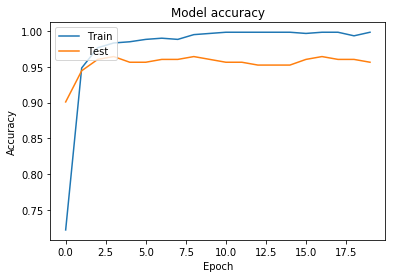

In [0]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


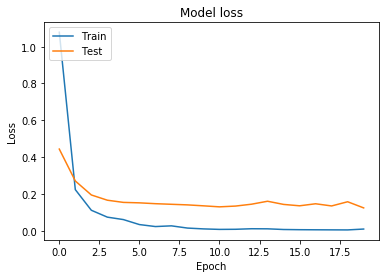

In [0]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Predictions

In [0]:
# threshold softmax
confidence_threshold = 0.020

In [0]:
def is_traffic_sign(bin_model, img):
    preds = bin_model.predict(np.expand_dims(cv2.resize(img, CROP_SIZE), axis=0))
    
    label = np.argmax(preds[0])
    
    if(label == 0):
        return(False)
    
    return(True)
   
    

0 / 300


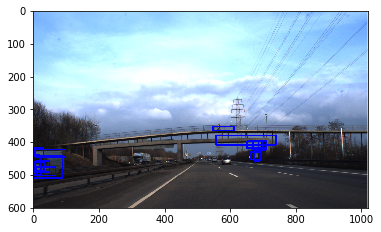

1 / 300


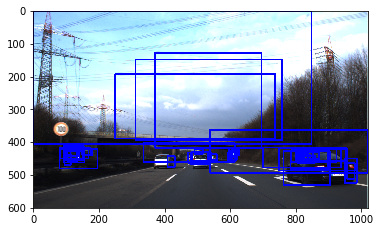

2 / 300


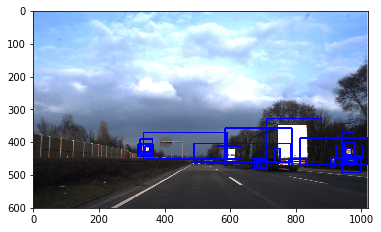

3 / 300


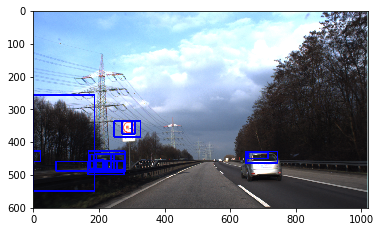

4 / 300


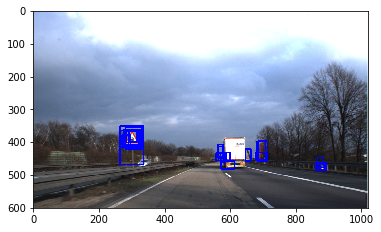

5 / 300


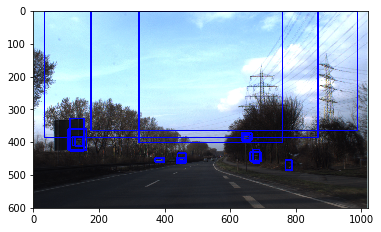

6 / 300


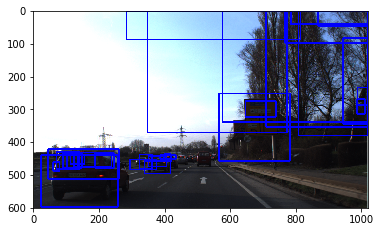

7 / 300


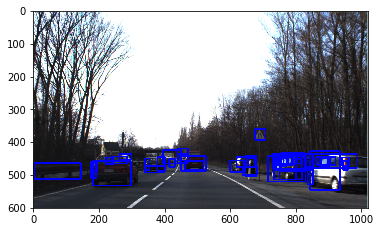

8 / 300


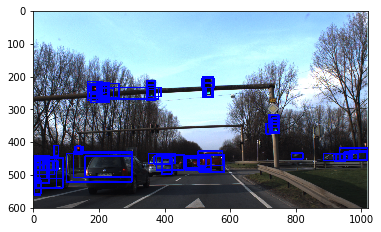

9 / 300


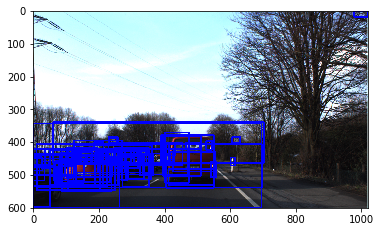

10 / 300


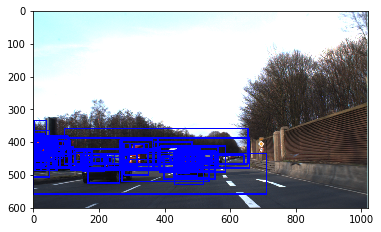

11 / 300


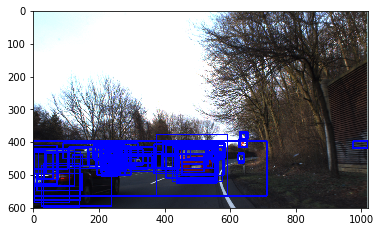

12 / 300


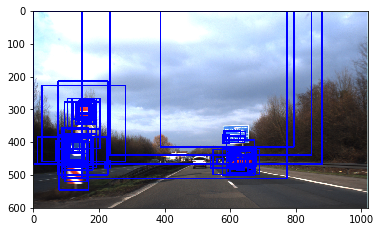

13 / 300


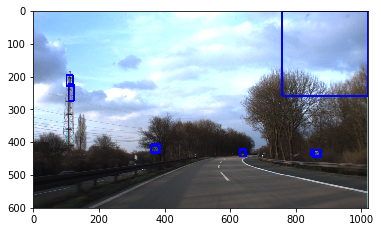

14 / 300


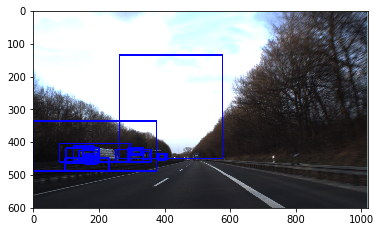

15 / 300


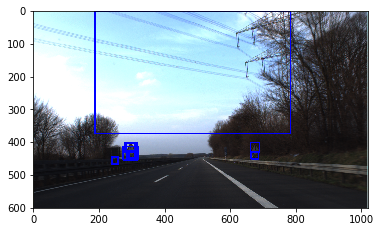

16 / 300


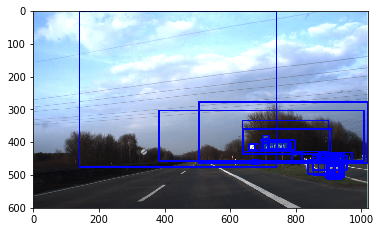

17 / 300


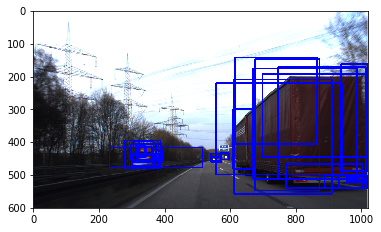

18 / 300


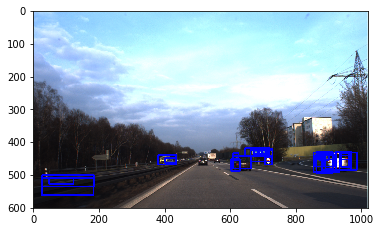

19 / 300


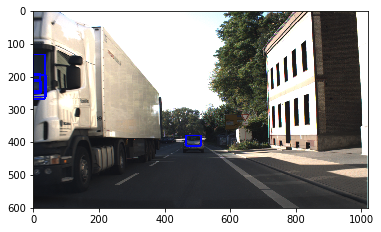

20 / 300


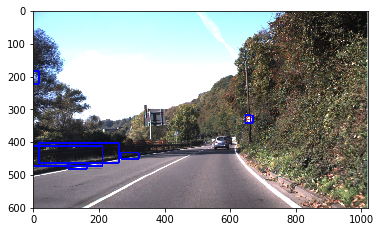

21 / 300


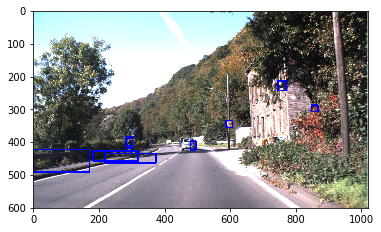

22 / 300


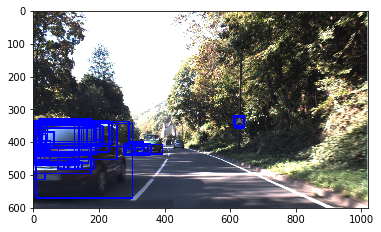

23 / 300


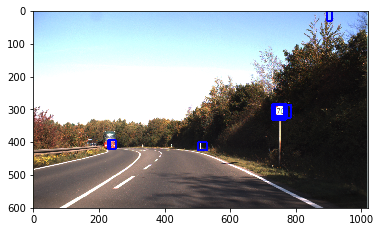

24 / 300


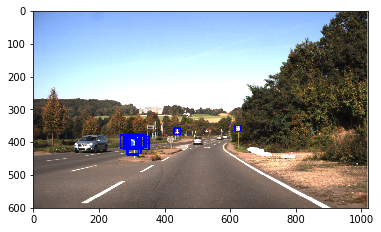

25 / 300


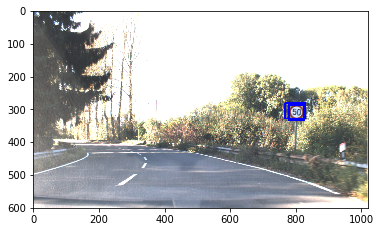

26 / 300


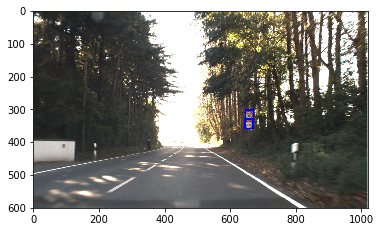

27 / 300


In [0]:
start = time()
i = 0

#test_images = shuffle(test_images)

for filename in test_images:
    
    print(str(i) + " / "+str(len(test_images)))
    i = i + 1
    prds_ofs = open('mAP/predicted/' + filename[-9:-4:] + '.txt', 'w')
    aux = test_images.get(filename)[0].copy()
    
    
    for bbox in test_pred.get(filename)[0]:
     
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        roi_resized = cv2.resize(roi, SIGN_SIZE)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE[0],SIGN_SIZE[1],3])
        # Run your own detector and save each traffic sign classification

        if is_traffic_sign(bin_classifier, roi_resized[0]):
            sign_class = predict_single_image(feature_extractor_model, 'mixed10', feature_extractor_model.layers[-3].output_shape[1:], model, roi_resized)[0, 0:num_classes]

            label = np.argmax(sign_class[0])
            confidence = sign_class[label]

            # traffic_sign_class confidence bbox
            prds_ofs.write(str(label) + ' ' + str(confidence) + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)

    prds_ofs.close()
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
end = time()
print("Traffic sign detection took " + str(end - start) + " seconds")

In [0]:
# Follow previous mAP code in order to evaluate the performance of your neural net
%cd -q mAP
%run main.py -na -np
%cd -q

22.73% = backpack AP 
85.94% = bed AP 
17.52% = book AP 
14.29% = bookcase AP 
23.48% = bottle AP 
31.86% = bowl AP 
7.93% = cabinetry AP 
53.84% = chair AP 
4.55% = coffeetable AP 
19.05% = countertop AP 
42.50% = cup AP 
39.66% = diningtable AP 
0.00% = doll AP 
20.69% = door AP 
7.69% = heater AP 
71.43% = nightstand AP 
42.86% = person AP 
17.71% = pictureframe AP 
13.01% = pillow AP 
62.31% = pottedplant AP 
73.21% = remote AP 
0.00% = shelf AP 
16.33% = sink AP 
90.48% = sofa AP 
1.39% = tap AP 
0.00% = tincan AP 
63.25% = tvmonitor AP 
18.75% = vase AP 
45.45% = wastecontainer AP 
23.53% = windowblind AP 
mAP = 31.05%


In [0]:
# Sample results obtained using my detector
46.54% = 1 AP 
54.70% = 10 AP 
54.20% = 11 AP 
54.07% = 12 AP 
66.81% = 13 AP 
66.75% = 14 AP 
72.33% = 15 AP 
100.00% = 16 AP 
65.48% = 17 AP 
26.45% = 18 AP 
44.28% = 2 AP 
37.50% = 22 AP 
69.44% = 23 AP 
0.00% = 24 AP 
43.19% = 25 AP 
54.76% = 26 AP 
20.00% = 28 AP 
0.00% = 29 AP 
53.95% = 3 AP 
70.00% = 30 AP 
0.00% = 31 AP 
35.50% = 32 AP 
86.67% = 33 AP 
83.33% = 34 AP 
76.33% = 35 AP 
0.00% = 36 AP 
0.00% = 37 AP 
41.90% = 38 AP 
0.00% = 39 AP 
52.49% = 4 AP 
55.56% = 40 AP 
0.00% = 41 AP 
69.17% = 42 AP 
57.24% = 5 AP 
57.14% = 6 AP 
33.96% = 7 AP 
65.57% = 8 AP 
70.15% = 9 AP 
mAP = 46.99%
<Figure size 432x288 with 0 Axes>